# Light-curve

In [2]:
%matplotlib inline 

import matplotlib.pyplot as plt, numpy as np, jdcal
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import griddata
import scipy.ndimage
from matplotlib.gridspec import GridSpec

plt.rc('font', family='serif')
plt.rc('text', usetex=True)

In [178]:
phot = np.genfromtxt('6478-ztf-photometry-binned.txt', skip_header=2, dtype=None)

phot0 = []

for photi in phot:
    if photi[-4].decode() == 'r':
        band = 2
    elif photi[-4].decode() == 'g':
        band = 1

    phot0.append([float(photi[-2]), float(photi[-1]), float(sum(jdcal.gcal2jd(photi[1].decode()[0:4], photi[1].decode()[5:7], photi[1].decode()[8:10]), \
                                          float(photi[2].decode()[0:2])/24+float(photi[2].decode()[3:5])/1440+float(photi[2].decode()[6:8])/86400)), \
                 band])

phot0 = np.array(phot0).astype('float').T

In [180]:
hg = np.genfromtxt('6478-HG-model.txt', skip_header=2, dtype=None).T

In [179]:
horizons = np.genfromtxt('horizons.txt', usecols=(0, 10)).T

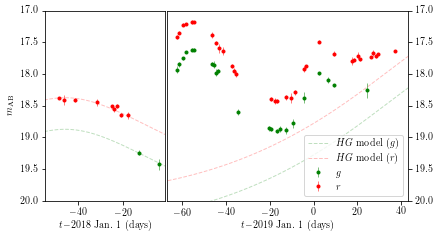

In [249]:
fig = plt.figure(figsize=(6.5, 3.5))
gs=GridSpec(1,2, width_ratios=[1, 2])
gs.update(wspace=0.01)
ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1])

ax0.plot(hg[0]-2458120.5, hg[-1], '--', color='g', alpha=0.25, label=r'HG model ($g$)', linewidth=1)
ax0.plot(hg[0]-2458120.5, hg[-2], '--', color='r', alpha=0.25, label=r'HG model ($r$)', linewidth=1)
ax0.errorbar(phot0[2][np.where(phot0[3]==1)]-2458120.5, phot0[0][np.where(phot0[3]==1)], yerr=phot0[1][np.where(phot0[3]==1)], \
             marker='.', color='g', linestyle='', label=r'$g$', elinewidth=0.5)
ax0.errorbar(phot0[2][np.where(phot0[3]==2)]-2458120.5, phot0[0][np.where(phot0[3]==2)], yerr=phot0[1][np.where(phot0[3]==2)], \
             marker='.', color='r', linestyle='', label=r'$r$', elinewidth=0.5)
ax0.set_xlim([-55, -1])
ax0.set_ylim([17.0, 20.0])
ax0.set_xlabel('$t-$2018 Jan. 1 (days)')
ax0.set_ylabel('$m_\mathrm{AB}$')

ax1.plot(hg[0]-2458485.5, hg[-1], '--', color='g', alpha=0.25, label=r'$HG$ model ($g$)', linewidth=1)
ax1.plot(hg[0]-2458485.5, hg[-2], '--', color='r', alpha=0.25, label=r'$HG$ model ($r$)', linewidth=1)
ax1.errorbar(phot0[2][np.where(phot0[3]==1)]-2458485.5, phot0[0][np.where(phot0[3]==1)], yerr=phot0[1][np.where(phot0[3]==1)], \
             marker='.', color='g', linestyle='', label=r'$g$', elinewidth=0.5)
ax1.errorbar(phot0[2][np.where(phot0[3]==2)]-2458485.5, phot0[0][np.where(phot0[3]==2)], yerr=phot0[1][np.where(phot0[3]==2)], \
             marker='.', color='r', linestyle='', label=r'$r$', elinewidth=0.5)
ax1.tick_params(left=False, labelleft=False, right=True, labelright=True)
ax1.set_xlim([-67, 43])
ax1.set_ylim([17.0, 20.0])
ax1.set_xlabel('$t-$2019 Jan. 1 (days)')

ax1.legend(loc=4)
ax0.set_ylim(ax0.get_ylim()[::-1])
ax1.set_ylim(ax1.get_ylim()[::-1])
plt.savefig('fig-lc.pdf')
plt.show()

# 2018/2019 light-curve, reduced to common baseline

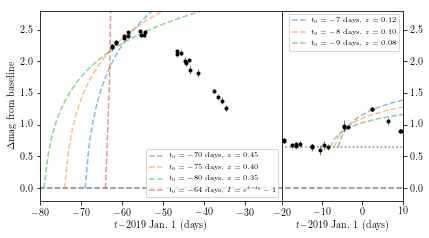

In [250]:
fig = plt.figure(figsize=(6.5, 3.5))
gs=GridSpec(1,2, width_ratios=[2, 1])
gs.update(wspace=0.0)
ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1])

g_norm = []
r_norm = []

for i, _ in enumerate(phot0[0]):
    if phot0[3][i] == 1:
        g_norm.append(phot0[0][i] - hg[-1][np.abs(hg[0] - phot0[2][i]).argmin()])
    elif phot0[3][i] == 2:
        r_norm.append(phot0[0][i] - hg[-2][np.abs(hg[0] - phot0[2][i]).argmin()])

g_norm = np.array(g_norm)
r_norm = np.array(r_norm)
        
ax0.errorbar(phot0[2][np.where(phot0[3]==1)]-2458485.5, -g_norm, yerr=phot0[1][np.where(phot0[3]==1)], \
             marker='.', color='k', linestyle='', elinewidth=0.5)
ax0.errorbar(phot0[2][np.where(phot0[3]==2)]-2458485.5, -r_norm, yerr=phot0[1][np.where(phot0[3]==2)], \
             marker='.', color='k', linestyle='', elinewidth=0.5)
ax1.errorbar(phot0[2][np.where(phot0[3]==1)]-2458485.5, -g_norm, yerr=phot0[1][np.where(phot0[3]==1)], \
             marker='.', color='k', linestyle='', elinewidth=0.5)
ax1.errorbar(phot0[2][np.where(phot0[3]==2)]-2458485.5, -r_norm, yerr=phot0[1][np.where(phot0[3]==2)], \
             marker='.', color='k', linestyle='', elinewidth=0.5)

ax0.set_xlabel('$t-$2019 Jan. 1 (days)')
ax0.set_ylabel(r'$\Delta$mag from baseline')

ax0.plot([-120, 30], [0, 0], '--', color='k', alpha=0.5)

# overlaying functions

def sq_law(x, z):  # z is a TBD constant
    return 5*z*np.log10(x)

def expo(x, z, a):
    return a*(np.exp(z*x)-1)

x = np.arange(0, 40, 1)
ax0.plot(x-70, sq_law(x, 0.45), '--', label=r'$t_0=-70$ days, $z=0.45$', alpha=0.5)
ax0.plot(x-75, sq_law(x, 0.40), '--', label=r'$t_0=-75$ days, $z=0.40$', alpha=0.5)
ax0.plot(x-80, sq_law(x, 0.35), '--', label=r'$t_0=-80$ days, $z=0.35$', alpha=0.5)
ax0.plot(x-64, expo(x, 1, 1), '--', label=r'$t_0=-64$ days, $I=e^{t-t_0}-1$', alpha=0.5)

#x = np.arange(0, 60, 1)
#ax.plot(x-120, expo(x, 0.04, 0.1), ':', label='Exponential')
#ax.plot(x-9, expo(x, 0.03, 0.1), ':', label='Exponential')

ax0.set_xlim([-80, -21])
ax0.set_ylim([-0.2, 2.8])
ax0.legend(fontsize='x-small')

ax1.set_xlim([-20, 10])
ax1.set_ylim([-0.2, 2.8])
ax1.set_xlabel('$t-$2019 Jan. 1 (days)')
ax1.plot([-120, 30], [0.0, 0.0], '--', color='gray')
ax1.plot([-120, 30], [0.65, 0.65], ':', color='gray')

x = np.arange(0, 30, 1)
ax1.plot(x-7, sq_law(x, 0.12)+0.65, '--', label=r'$t_0=-7$ days, $z=0.12$', alpha=0.5)
ax1.plot(x-8, sq_law(x, 0.10)+0.65, '--', label=r'$t_0=-8$ days, $z=0.10$', alpha=0.5)
ax1.plot(x-9, sq_law(x, 0.08)+0.65, '--', label=r'$t_0=-9$ days, $z=0.08$', alpha=0.5)

#ax1.set_ylabel(r'$\Delta$mag from mid-Dec. 2018')
ax1.yaxis.set_label_position('right')
ax1.tick_params(left=False, labelleft=False, right=True, labelright=True)
ax1.legend(fontsize='x-small')

plt.savefig('fig-lc-norm.pdf')
plt.show()